# Description

This notebook runs some pre-analyses using DBSCAN to explore the best set of parameters (`min_samples` and `eps`) to cluster `pca` data version.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

4

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=4
env: OPEN_BLAS_NUM_THREADS=4
env: NUMEXPR_NUM_THREADS=4
env: OMP_NUM_THREADS=4


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name
from clustering.ensembles.utils import generate_ensemble

# Global settings

In [5]:
np.random.seed(0)

In [6]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

# Data version: pca

In [7]:
INPUT_SUBSET = "pca"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
DR_OPTIONS = {
    "n_components": 50,
    "svd_solver": "full",
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base/results/data_transformations/pca/pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full.pkl')

'pca-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-n_components_50-random_state_0-svd_solver_full'

In [11]:
data = pd.read_pickle(input_filepath)

In [12]:
data.shape

(3752, 50)

In [13]:
data.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,...,PCA41,PCA42,PCA43,PCA44,PCA45,PCA46,PCA47,PCA48,PCA49,PCA50
100001_raw-Food_weight,0.805216,-0.865390,0.699480,-0.065976,0.999617,-0.418645,1.993288,-0.346875,-1.522978,-2.382791,...,0.777932,0.507896,0.693668,1.024260,0.189606,-1.661826,0.281234,-0.096792,-0.339508,0.041431
100002_raw-Energy,0.588507,-1.491772,1.756340,-3.593295,2.100607,0.364910,1.254815,2.028484,-0.357607,-4.832726,...,-0.780215,-2.285033,-0.607663,-2.727018,1.711667,-0.535025,2.342068,0.197519,1.636996,-1.114410
100003_raw-Protein,1.910160,-1.873687,1.876677,-3.832557,1.240704,2.941375,2.293978,0.802473,0.665380,-4.375319,...,-0.547161,0.514721,0.034145,-0.423218,-0.324825,-0.000958,0.294579,1.186937,0.226722,0.169931
100004_raw-Fat,0.750799,-0.294733,1.317710,-1.346081,2.006403,0.533509,-0.752916,0.937515,-0.572191,-2.451612,...,0.060359,-0.878309,-0.774943,-1.914890,2.559763,1.547267,1.851110,-0.310431,3.495624,-1.595785
100005_raw-Carbohydrate,-0.530044,-0.007398,0.611418,-3.604094,2.227872,0.051271,0.001135,2.303819,-0.387759,-5.686184,...,-1.110273,-3.032541,-1.223873,-0.945626,2.150276,-1.798716,2.526678,0.716987,0.300972,-0.893854


## Tests different k values (k-NN)

In [14]:
k_values = np.arange(2, 125 + 1, 1)
k_values_to_explore = (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125)

In [15]:
results = {}

for k in k_values_to_explore:
    nbrs = NearestNeighbors(n_neighbors=k, n_jobs=N_JOBS).fit(data)
    distances, indices = nbrs.kneighbors(data)
    results[k] = (distances, indices)

In [16]:
eps_range_per_k = {
    k: (10, 20)
    if k < 5
    else (11, 25)
    if k < 10
    else (12, 30)
    if k < 15
    else (13, 35)
    if k < 20
    else (14, 40)
    for k in k_values
}

eps_range_per_k_to_explore = {k: eps_range_per_k[k] for k in k_values_to_explore}

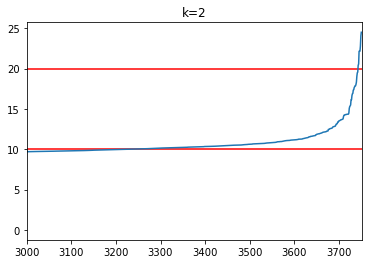

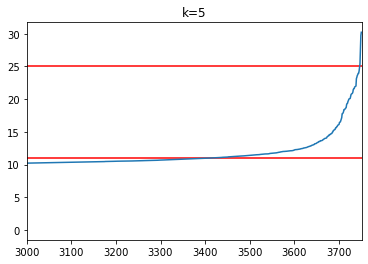

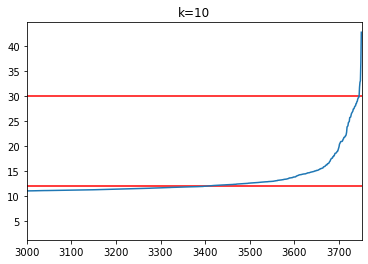

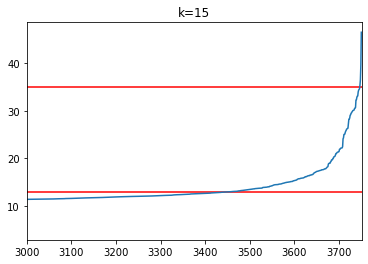

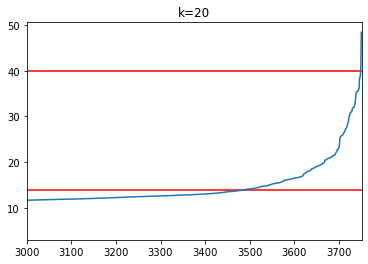

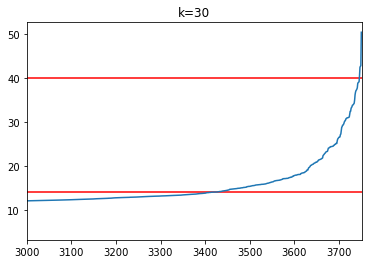

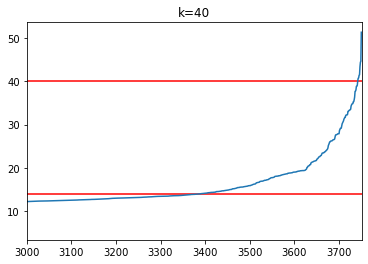

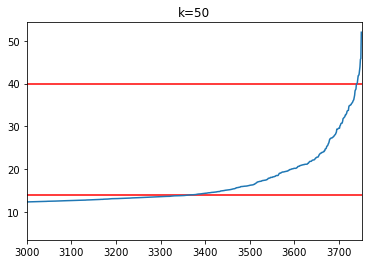

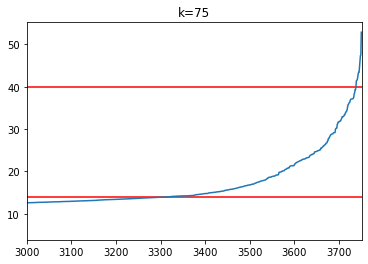

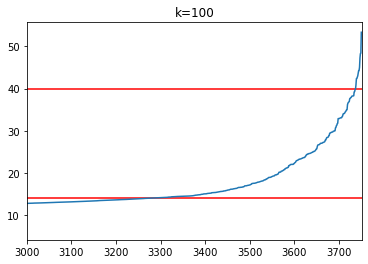

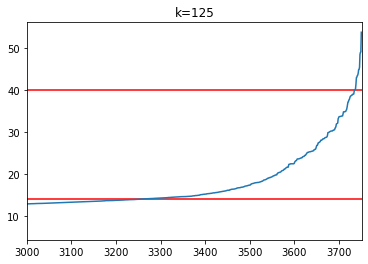

In [17]:
for k, (distances, indices) in results.items():
    d = distances[:, 1:].mean(axis=1)
    d = np.sort(d)

    fig, ax = plt.subplots()
    plt.plot(d)

    r = eps_range_per_k_to_explore[k]
    plt.hlines(r[0], 0, data.shape[0], color="red")
    plt.hlines(r[1], 0, data.shape[0], color="red")

    plt.xlim((3000, data.shape[0]))
    plt.title(f"k={k}")
    display(fig)

    plt.close(fig)

# Extended test

## Generate clusterers

In [18]:
CLUSTERING_OPTIONS = {}

# K_RANGE is the min_samples parameter in DBSCAN (sklearn)
CLUSTERING_OPTIONS["K_RANGE"] = k_values_to_explore
CLUSTERING_OPTIONS["EPS_RANGE_PER_K"] = eps_range_per_k_to_explore
CLUSTERING_OPTIONS["EPS_STEP"] = 33
CLUSTERING_OPTIONS["METRIC"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_RANGE': (2, 5, 10, 15, 20, 30, 40, 50, 75, 100, 125),
 'EPS_RANGE_PER_K': {2: (10, 20),
  5: (11, 25),
  10: (12, 30),
  15: (13, 35),
  20: (14, 40),
  30: (14, 40),
  40: (14, 40),
  50: (14, 40),
  75: (14, 40),
  100: (14, 40),
  125: (14, 40)},
 'EPS_STEP': 33,
 'METRIC': 'euclidean'}

In [19]:
CLUSTERERS = {}

idx = 0

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    eps_range = CLUSTERING_OPTIONS["EPS_RANGE_PER_K"][k]
    eps_values = np.linspace(eps_range[0], eps_range[1], CLUSTERING_OPTIONS["EPS_STEP"])

    for eps in eps_values:
        clus = DBSCAN(min_samples=k, eps=eps, metric="precomputed", n_jobs=N_JOBS)

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [20]:
display(len(CLUSTERERS))

363

In [21]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DBSCAN #0', DBSCAN(eps=10.0, metric='precomputed', min_samples=2, n_jobs=4))

('DBSCAN #1',
 DBSCAN(eps=10.3125, metric='precomputed', min_samples=2, n_jobs=4))

In [22]:
clustering_method_name = method_name
display(clustering_method_name)

'DBSCAN'

## Generate ensemble

In [23]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["METRIC"])

In [24]:
data_dist.shape

(3752, 3752)

In [25]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14077504.0
mean     17.024782042246752
std       6.762137212106086
min                     0.0
25%      13.389339109103538
50%      15.000767361972102
75%       17.54736953003761
max       74.26751471437031
dtype: object

In [26]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 363/363 [01:15<00:00,  4.84it/s]


In [27]:
ensemble.shape

(111, 3)

In [28]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 10.0, 'leaf_size'...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",333
DBSCAN #1,"{'algorithm': 'auto', 'eps': 10.3125, 'leaf_si...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",275
DBSCAN #2,"{'algorithm': 'auto', 'eps': 10.625, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",221
DBSCAN #3,"{'algorithm': 'auto', 'eps': 10.9375, 'leaf_si...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",173
DBSCAN #4,"{'algorithm': 'auto', 'eps': 11.25, 'leaf_size...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",135


In [30]:
_tmp = ensemble["n_clusters"].value_counts()
display(_tmp)
assert _tmp.index[0] == 3
assert _tmp.loc[3] == 22

3      22
2      21
5       9
6       8
7       8
16      4
14      3
17      3
9       3
35      2
34      2
4       2
20      1
13      1
8       1
15      1
135     1
18      1
275     1
26      1
22      1
105     1
25      1
45      1
29      1
33      1
40      1
42      1
173     1
19      1
55      1
69      1
333     1
86      1
221     1
23      1
Name: n_clusters, dtype: int64

In [31]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    111.000000
mean      21.774775
std       50.178352
min        2.000000
25%        3.000000
50%        6.000000
75%       16.500000
max      333.000000
Name: n_clusters, dtype: float64

In [32]:
# number of noisy points
_tmp = ensemble.copy()
_tmp = _tmp.assign(n_noisy=ensemble["partition"].apply(lambda x: np.isnan(x).sum()))

In [34]:
_tmp_stats = _tmp["n_noisy"].describe()
display(_tmp_stats)
assert _tmp_stats["min"] > 5
assert _tmp_stats["max"] < 600
assert 90 < _tmp_stats["mean"] < 95

count    111.000000
mean      92.711712
std      105.142880
min        8.000000
25%       26.000000
50%       55.000000
75%      111.500000
max      586.000000
Name: n_noisy, dtype: float64

## Testing

In [35]:
assert ensemble_stats["min"] > 1

In [36]:
assert not ensemble["n_clusters"].isna().any()

In [37]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

## Add clustering quality measures

In [38]:
def _remove_nans(data, part):
    not_nan_idx = ~np.isnan(part)
    return data.iloc[not_nan_idx], part[not_nan_idx]


def _apply_func(func, data, part):
    no_nan_data, no_nan_part = _remove_nans(data, part)
    return func(no_nan_data, no_nan_part)

In [39]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(
        lambda x: _apply_func(silhouette_score, data, x)
    ),
    ch_score=ensemble["partition"].apply(
        lambda x: _apply_func(calinski_harabasz_score, data, x)
    ),
    db_score=ensemble["partition"].apply(
        lambda x: _apply_func(davies_bouldin_score, data, x)
    ),
)

In [40]:
ensemble.shape

(111, 6)

In [41]:
ensemble.head()

,clusterer_params,partition,n_clusters,si_score,ch_score,db_score
clusterer_id,,,,,,
DBSCAN #0,"{'algorithm': 'auto', 'eps': 10.0, 'leaf_size'...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",333,0.089548,10.283978,0.897203
DBSCAN #1,"{'algorithm': 'auto', 'eps': 10.3125, 'leaf_si...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",275,0.056570,10.762233,0.889088
DBSCAN #2,"{'algorithm': 'auto', 'eps': 10.625, 'leaf_siz...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",221,0.034014,11.826229,0.871643
DBSCAN #3,"{'algorithm': 'auto', 'eps': 10.9375, 'leaf_si...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, ...",173,0.029440,13.902646,0.826430
DBSCAN #4,"{'algorithm': 'auto', 'eps': 11.25, 'leaf_size...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",135,0.031377,15.678458,0.790754


# Cluster quality

In [42]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,si_score,ch_score,db_score
n_clusters,,,
2,0.574761,135.274982,0.642492
3,0.555237,136.316817,0.611921
4,0.407810,109.354172,0.690375
5,0.537684,79.622414,0.534207
6,0.515307,73.285827,0.527142
7,0.487367,94.770382,0.680738
8,0.480435,81.774679,0.666639
9,0.320912,79.965049,0.693480
13,0.250632,64.905234,0.630862


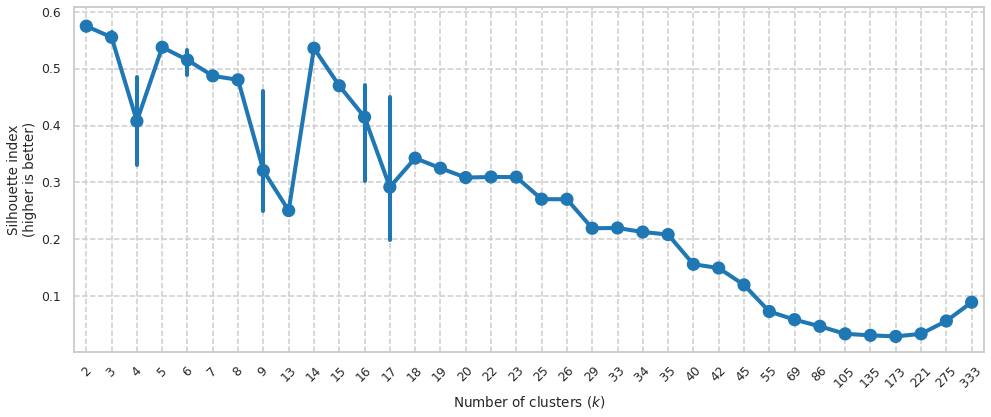

In [43]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

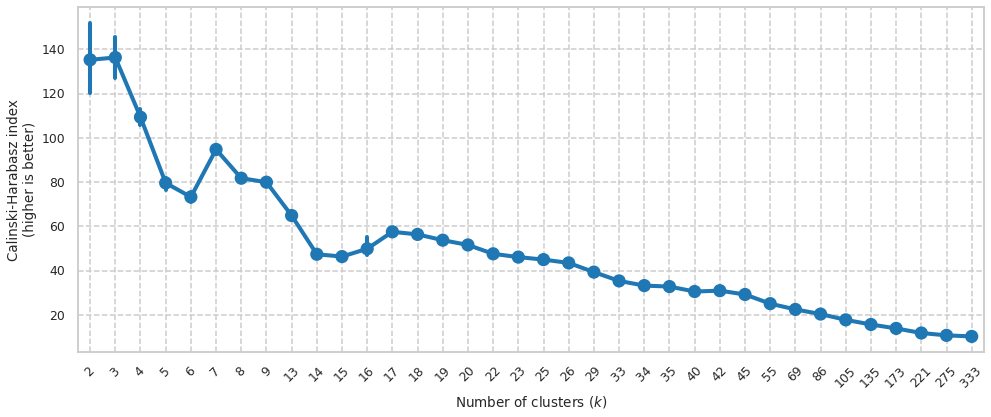

In [44]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

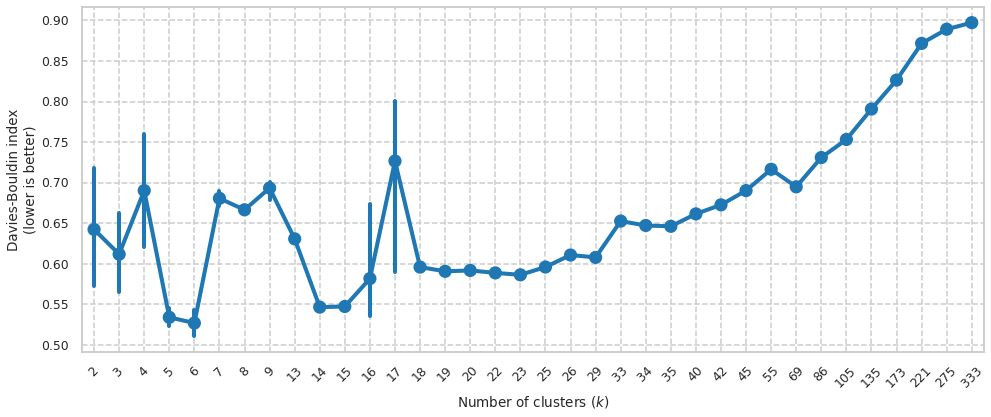

In [45]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Conclusions

The values explored above for `k_values` and `eps_range_per_k` are the one that will be used for DBSCAN in this data version.